In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define Generator and Discriminator for time series
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.initialize_weights()
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.linear(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Only use the last output
        return self.sigmoid(x)

# Hyperparameters
seq_len = 50
input_dim = 24
hidden_dim = 128
batch_size = 32

# Initialize models and optimizers
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)

# Loss function
criterion = nn.BCELoss()

# Generate synthetic time series data (e.g., sine waves with noise)
def generate_real_data(batch_size, seq_len):
    time = np.linspace(0, 10, seq_len)
    data = np.sin(time) + np.random.normal(0, 0.1, (batch_size, seq_len))
    return torch.FloatTensor(data).unsqueeze(-1)


In [48]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Generate real data
    real_data = generate_real_data(batch_size, seq_len)

    # Train Discriminator
    d_optimizer.zero_grad()
    
    # Real data
    real_labels = torch.ones(batch_size, 1)
    outputs = discriminator(real_data)
    d_loss_real = criterion(outputs, real_labels)
    
    # Fake data
    z = torch.randn(batch_size, seq_len, input_dim)
    fake_data = generator(z)
    fake_labels = torch.zeros(batch_size, 1)
    outputs = discriminator(fake_data.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, seq_len, input_dim)
    fake_data = generator(z)
    outputs = discriminator(fake_data)
    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

Epoch [10/100], d_loss: 0.7310, g_loss: 4.6469
Epoch [20/100], d_loss: 0.4645, g_loss: 4.0818
Epoch [30/100], d_loss: 0.7443, g_loss: 2.8899
Epoch [40/100], d_loss: 0.3315, g_loss: 1.8577
Epoch [50/100], d_loss: 0.0563, g_loss: 3.3687
Epoch [60/100], d_loss: 0.0185, g_loss: 4.6678
Epoch [70/100], d_loss: 0.0108, g_loss: 5.3165
Epoch [80/100], d_loss: 0.0087, g_loss: 5.7544
Epoch [90/100], d_loss: 0.0093, g_loss: 6.0587
Epoch [100/100], d_loss: 0.0062, g_loss: 5.7737


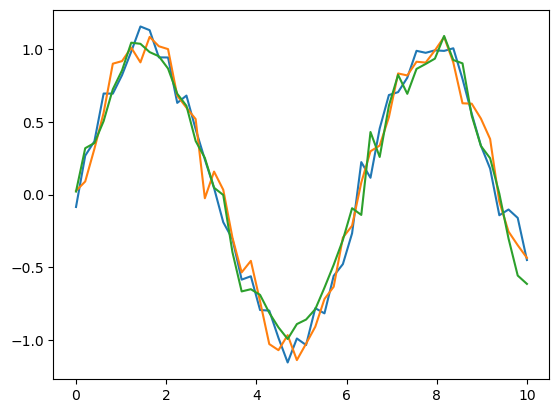

In [49]:
# Actual data
import matplotlib.pyplot as plt
for i in range(3):
    time = np.linspace(0, 10, seq_len)
    real_data = np.sin(time) + np.random.normal(0, 0.1, seq_len)
    plt.plot(time, real_data, label='Real data')

Generated sample shape: (10, 50)


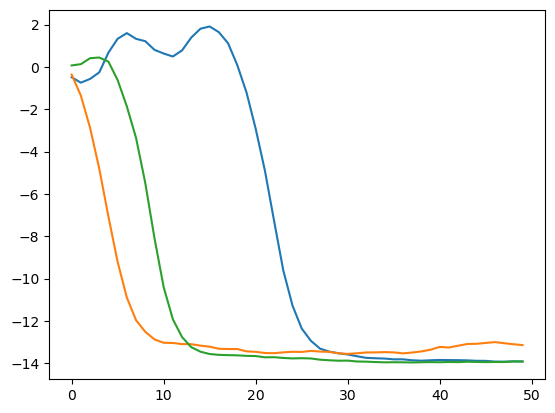

In [50]:
from matplotlib import pyplot as plt 
# Generate a sample after training
with torch.no_grad():
    z = torch.randn(10, seq_len, input_dim)
    generated_sample = generator(z).squeeze().numpy()
    print("Generated sample shape:", generated_sample.shape)

for i in range(3):
    plt.plot(generated_sample[i], label=f'Sample {i+1}')